In [1]:
from Angrybird import AngryBird
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
env = AngryBird()

In [3]:
env.reset()
for i in range(11):
    print(env.step(np.zeros(2)))

(array([ 1.        , 10.15185547, 17.26386903]), 0.0, False, None)
(array([ 2.        , 21.76652771, 29.63619301]), 0.0, False, None)
(array([ 3.        , 34.28623818, 36.88575945]), 0.0, False, None)
(array([ 4.        , 46.61804329, 38.51243041]), 0.0, False, None)
(array([ 5.        , 60.84850253, 34.75249055]), 0.0, False, None)
(array([ 6.        , 74.66268807, 28.26829364]), 0.0, False, None)
(array([ 7.        , 89.54018722, 16.83698113]), 0.0, False, None)
(array([  8.        , 104.58188232,   0.77910321]), 0.0, False, None)
(array([  9.        , 119.97247436, -20.46376774]), 0.0, False, None)
(array([ 10.        , 135.07765983, -45.48388739]), 0.0, False, None)
(array([ 10.        , 135.07765983, -45.48388739]), 13034.47056664047, True, None)


In [55]:
force = np.array([0., 0.])
new_force = np.zeros(2)
costs = []
for i in range(1000):
    state = env.reset()
    cost = 0.
    for j in range(10):
        state, reward, done, _ = env.step(force)
        cost += reward
    costs.append(cost)
np.mean(costs)

1601.583202870098

[ 32.13067275 -14.53676325] [83.93466362  7.26838162]
[ 0.34342267 -0.00687511] [9.98282887e+01 3.43755730e-03]


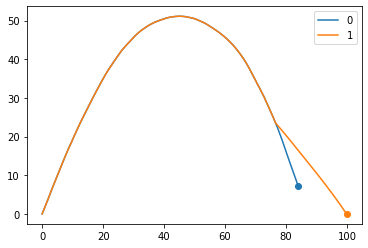

In [8]:
force = np.array([0., 0.])
m = 100
for j in range(2):
    new_force = np.zeros(2)
    for i in range(m):
        env.reset_s(9)
        state, reward, done, _ = env.step(force)
        if i == 0:
            traj = np.array(env.trajectoire)
            plt.plot(traj[:, 1], traj[:, 2], label="{}".format(j))
            plt.scatter(traj[-1][1], traj[-1][2])
            print(-env.g_prime(), state[1:])
        new_force += -env.g_prime()
    force = new_force / m / 2
plt.legend()

In [9]:
env.cost.sum()

319.4533511171691

In [8]:
env.g_func()

349.84000000000003

In [7]:
env.X = np.array([10., 83., 7.8])
env.g_prime()

array([-34. ,  15.6])

In [3]:
class Model():
    def __init__(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(4, input_shape=(2,)))
        self.model.add(tf.keras.layers.Dense(4))
        self.model.add(tf.keras.layers.Dense(2))
        self.model.compile(optimizer='adam', loss='mse')
    def fit(self, X, Y):
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
        self.model.fit(X, Y, batch_size=32, epochs=200, verbose=0, callbacks=[es])
    def predict(self, x):
        return self.model.predict(x.reshape(1, 2))

In [4]:
%%time
dict_model = {}
dic_x_mean = np.zeros((10, 2))
dic_x_std = np.zeros((10, 2))
dic_y_mean = np.zeros((10, 2))
dic_y_std = np.zeros((10, 2))
for i in range(10):
    '''
    We use 10 models to predict the effect of wind for the next second (the sum of it)
    We use the result from the last models for the prediction
    '''
    dict_model[i] = Model()
    X = []
    Y = []
    for _ in tqdm(range(10000)):
        if i == 0:
            state = env.reset()
            X.append(np.copy(state[1:]))
            Y.append(env.vent[:10].sum(axis=0) * 0.1)
        else:
            state = env.reset()
            for j in range(i - 1):
                x_to_model = (state[1:] - dic_x_mean[j]) / dic_x_std[j]
                force_predict = dict_model[j].predict(x_to_model) * dic_y_std[j] + dic_y_mean[j]
                force_predict *= (0.55 + 0.05 * j)
                state, _, _, _ = env.step(force_predict)
            state, _, _, _ = env.step(np.zeros(2))
            X.append(np.copy(state[1:]))
            Y.append(env.vent[(10*i):(10*(i+1))].sum(axis=0) * 0.1)
    X = np.array(X)
    Y = np.array(Y)
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)
    y_mean = Y.mean(axis=0)
    y_std = Y.std(axis=0)
    if i == 0:
        x_std = np.ones(2)
        y_std = np.ones(2)
    dic_x_mean[i] = x_mean
    dic_x_std[i] = x_std
    dic_y_mean[i] = y_mean
    dic_y_std[i] = y_std
    X = (X - x_mean) / x_std
    Y = (Y - y_mean) / y_std
    print("Fitting for i = {}".format(i), end="\t")
    dict_model[i].fit(X, Y)
    print("Done!")


Fitting for i = 0	Epoch 00026: early stopping
Done!



Fitting for i = 1	Epoch 00018: early stopping
Done!



Fitting for i = 2	Epoch 00014: early stopping
Done!



Fitting for i = 3	Epoch 00015: early stopping
Done!



Fitting for i = 4	Epoch 00014: early stopping
Done!



Fitting for i = 5	Epoch 00015: early stopping
Done!



Fitting for i = 6	Epoch 00017: early stopping
Done!



Fitting for i = 7	Epoch 00015: early stopping
Done!



Fitting for i = 8	Epoch 00023: early stopping
Done!



Fitting for i = 9	Epoch 00028: early stopping
Done!
CPU times: user 1h 40min 55s, sys: 6min 18s, total: 1h 47min 13s
Wall time: 1h 38min 43s


In [5]:
cost = []
for i in range(1000):
    state = env.reset()
    for j in range(10):
        x_to_model = (state[1:] - dic_x_mean[j]) / dic_x_std[j]
        force_predict = dict_model[j].predict(x_to_model) * dic_y_std[j] + dic_y_mean[j]
        force_predict *= (0.55 + 0.05 * j)
        state, reward, _, _ = env.step(force_predict)
    if i % 100 == 0:
        print(state, reward)
    cost.append(reward)
print(np.mean(cost))

[ 10.         112.14762139 -14.65787217] 1449.1619944679014
[10.         11.30137291 75.81677748] 14066.4436743685
[ 10.         138.08645095 -46.17234169] 14370.047718102693
[ 10.         113.46194751 -21.74942168] 2554.9707789835925
[10.         72.02042095 17.82008271] 1142.0996981605642
[10.         79.87349943 16.36184186] 684.1296333142755
[ 10.         119.54576695 -28.139089  ] 4602.3799095289605
[ 10.         127.75954999 -38.27702558] 8917.036847197967
[10.         59.26190461 35.60095247] 3018.2581936922757
[ 10.         125.34477331 -30.35975925] 6322.220272883268
5818.787630873089


In [3]:
meanx = np.load("meanx.npy")
meany = np.load("meany.npy")
stdx = np.load("stdx.npy")
stdy = np.load("stdy.npy")

In [37]:
def test_coeff(coeff, display=True):
    state = env.reset()
    for i in range(10):
        if i == 0:
            state, reward, done, _ = env.step(np.array([0., 0.]))
        else:
            force = np.array([-(state[1] - meanx[i-1]) * coeff * stdx[i-1], 
                              -(state[2] - meany[i-1]) * coeff * stdy[i-1]])
            #print(force)
            state, reward, done, _ = env.step(force)
        #print(reward)
    if display:
        traj = np.array(env.trajectoire)
        plt.plot(traj[:, 1], traj[:, 2])
        plt.scatter(traj[-1][1], traj[-1][2])
        #print(traj[-10:])
    return reward

In [52]:
%%time
mean_rewards = []
for l in np.arange(0.003, 0.028, step=0.0001):
    coeff = l
    rewards = []
    for j in range(1000):
        rewards.append(test_coeff(coeff, display=False))
    mean_rewards.append([l, np.mean(rewards)])
mean_rewards = np.array(mean_rewards)
np.where(mean_rewards[:, 1] == mean_rewards[:, 1].min())

CPU times: user 7min 12s, sys: 54.7 ms, total: 7min 12s
Wall time: 7min 13s


(array([219]),)

<IPython.core.display.Javascript object>


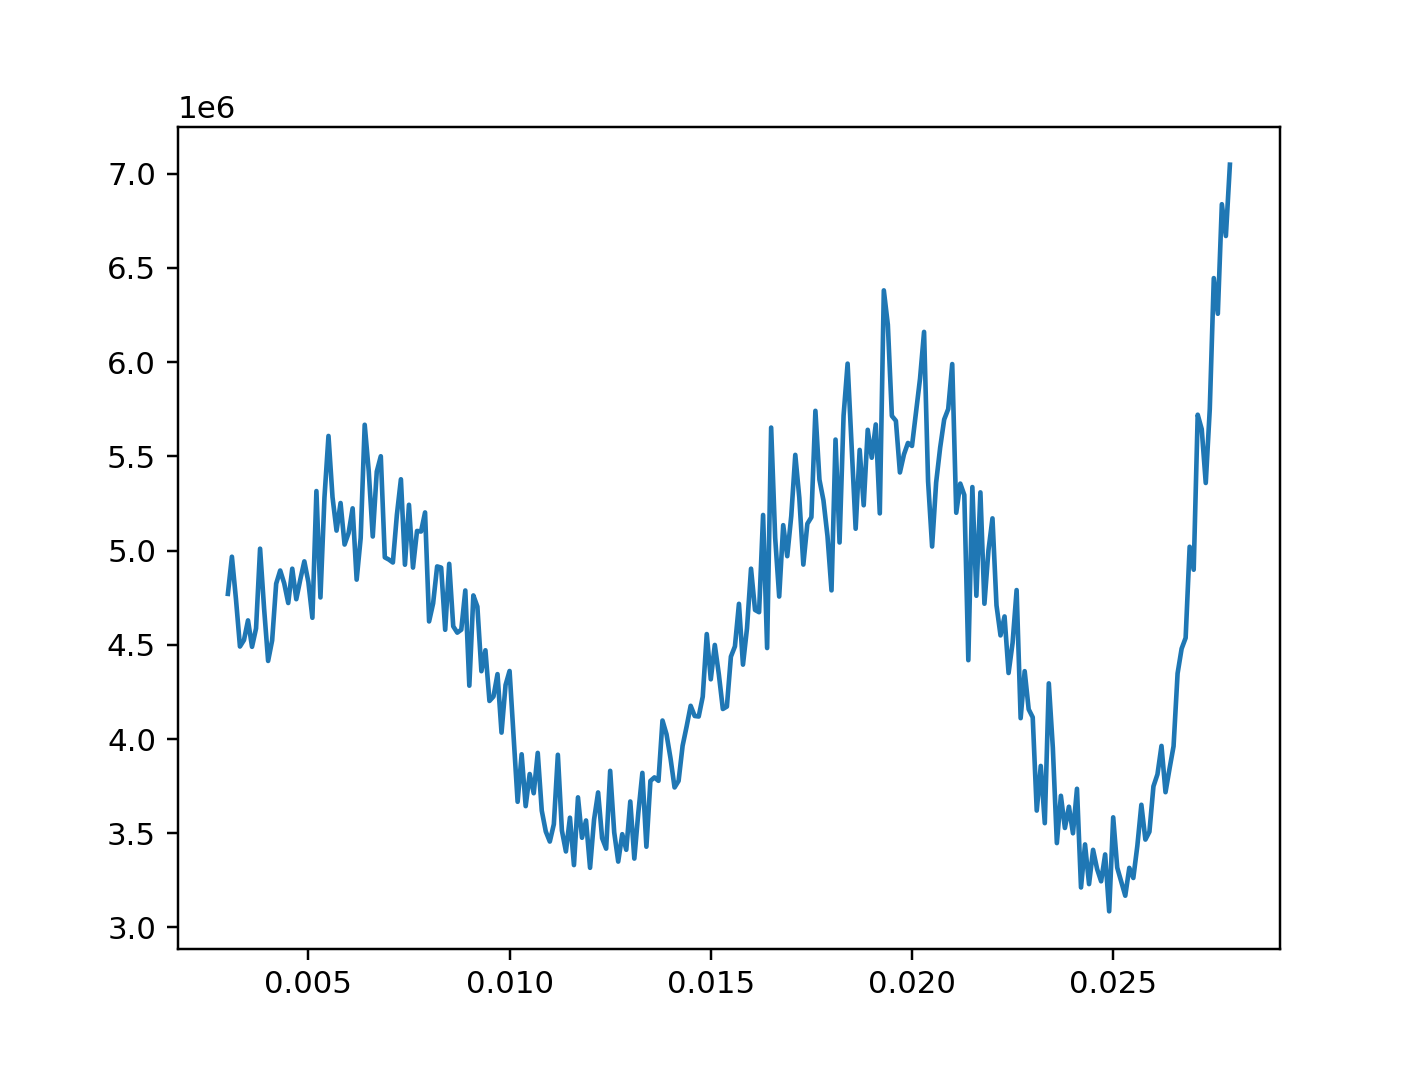

In [53]:
%matplotlib notebook
plt.figure()
plt.plot(mean_rewards[:, 0], mean_rewards[:, 1])

In [54]:
mean_rewards[219]

array([2.49000000e-02, 3.08564587e+06])

<IPython.core.display.Javascript object>


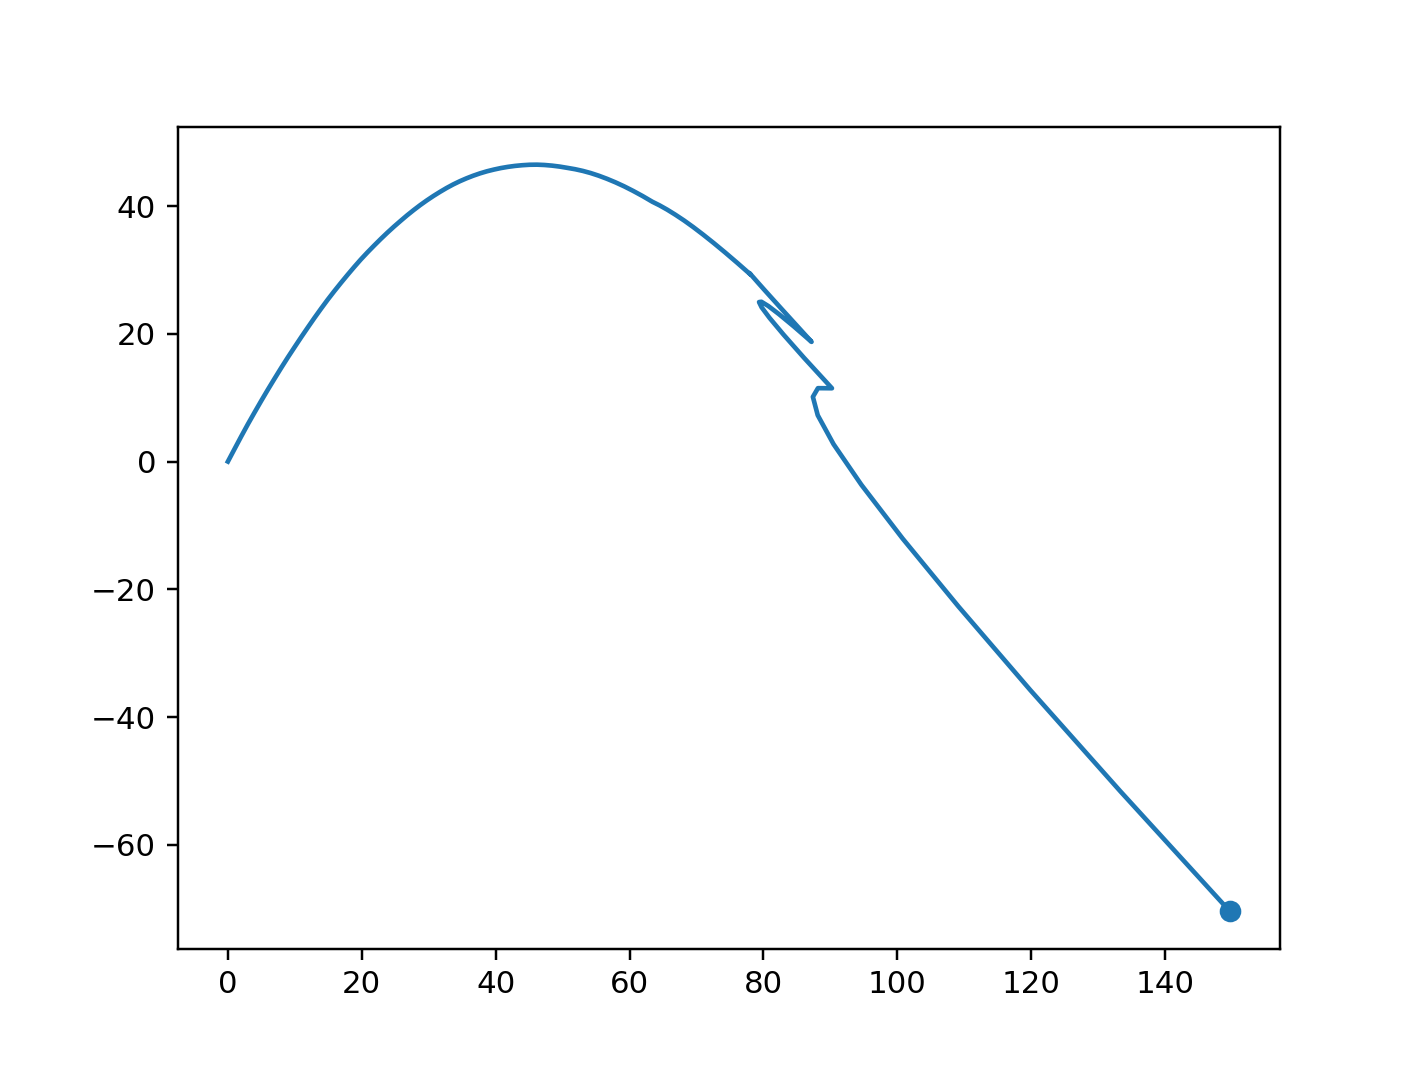

89670.67372781638

In [59]:
plt.figure()
test_coeff(0.0249)

$$
V_t = 0.2\int_{0}^{t}e^{(s-t)A}dW_s
$$

In [5]:
from scipy.linalg import expm
A = np.array([[0.9, 1], [1, 0.9]])
Deltat = 0.1
cov = np.linalg.inv(A).dot(np.eye(2) - expm(-2*Deltat*A)) / 2
coeff = expm(-Deltat * A)

def init_vent():
    X = np.random.multivariate_normal(mean=np.zeros(shape=2), cov=cov, size=100)
    vent = np.zeros(shape=(100, 2))
    for i in range(1, 100):
        vent[i] = X[i-1] + np.matmul(coeff, vent[i-1])
    return vent

In [12]:
np.linalg.inv(A)

array([[-4.73684211,  5.26315789],
       [ 5.26315789, -4.73684211]])

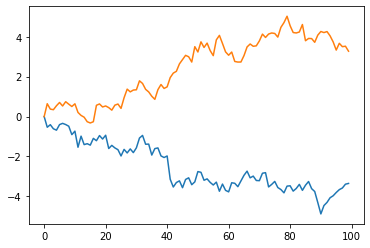

In [11]:
import matplotlib.pyplot as plt
vent = init_vent()
plt.plot(vent[:, 0])
plt.plot(vent[:, 1])